<a href="https://colab.research.google.com/github/DaniChinwendu/skin-sensitization-prediction/blob/main/Train_and_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Skin Sensitization Prediction - Google Colab Notebook
Supports multiple fingerprint types: MACCS, Avalon, RDKit AtomPair, PubChem

OPTIMIZING SKIN SENSITIZATION PREDICTION: A COMPARATIVE ANALYSIS OF KNN VS RANDOM FOREST

Daniel C. Ukaegbu 1, Karolina Kopanska 1, Peter Ranslow 2, Alexandra Maertens 1*
1 Center for Alternatives to Animal Testing (CAAT), Johns Hopkins Bloomberg School of Public Health, Baltimore, Maryland 21205, United States
2 Consortium for Environmental Risk Management (CERM), Hallowell, Maine 04347, United States
*Correspondence:
Alexandra Maertens
amaerte1@jhu.edu

"""

In [1]:


# ============================================================================
# SECTION 1: Install Dependencies (Run this first in Colab)
# ============================================================================

# Uncomment and run if packages are not installed
!pip install rdkit shap

# ============================================================================
# SECTION 2: Import Libraries
# ============================================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import warnings
warnings.filterwarnings('ignore')

from base64 import b64decode

from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, precision_recall_fscore_support,
                             classification_report)

from rdkit import Chem
from rdkit.Chem import MACCSkeys, rdMolDescriptors
from rdkit.Avalon import pyAvalonTools

print("✓ All libraries imported successfully!")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.6/36.6 MB 10.6 MB/s eta 0:00:00
✓ All libraries imported successfully!


In [2]:
# ============================================================================
# SECTION 3: Load Your Data Files
# ============================================================================

from google.colab import files
import io

print("Upload your TRAINING data CSV file:")
uploaded_train = files.upload()
train_filename = list(uploaded_train.keys())[0]
df_train = pd.read_csv(io.BytesIO(uploaded_train[train_filename]))

print(f"\n✓ Training data loaded: {len(df_train)} samples")
print(f"  Columns: {list(df_train.columns)}")
print(f"\nFirst few rows of training data:")
display(df_train.head())

print("\n" + "="*60)
print("Upload your TEST data CSV file:")
uploaded_test = files.upload()
test_filename = list(uploaded_test.keys())[0]
df_test = pd.read_csv(io.BytesIO(uploaded_test[test_filename]))

print(f"\n✓ Test data loaded: {len(df_test)} samples")
print(f"  Columns: {list(df_test.columns)}")
print(f"\nFirst few rows of test data:")
display(df_test.head())


Upload your TRAINING data CSV file:


Saving df_train.csv to df_train.csv

✓ Training data loaded: 939 samples
  Columns: ['InChIKey', 'DATATYPE', 'VALUE', 'H317', 'smiles', 'Moleculer_weight', 'TPSA', 'CID', 'BOILING_POINT_DEGC_OPERA_PRED', 'OCTANOL_WATER_PARTITION_LOGP_OPERA_PRED', 'MELTING_POINT_DEGC_OPERA_PRED', 'VAPOR_PRESSURE_MMHG_OPERA_PRED', 'WATER_SOLUBILITY_MOL/L_OPERA_PRED', 'IUPAC NAME', 'PUBCHEMFP', 'SUPER CLASS', 'CLASS', 'SUBCLASS', 'Alert for Acyl Transfer Agent', 'Alert For Micheal Acceptors', 'Alert for SN2', 'Alert for SNAR', 'Alert for Schiff base', 'No Skin Sensitization', 'Number of alert', 'HOMO', 'LUMO', 'Pubchem Bits', 'pubchem Bit Vector']

First few rows of training data:


,InChIKey,DATATYPE,VALUE,H317,smiles,Moleculer_weight,TPSA,CID,BOILING_POINT_DEGC_OPERA_PRED,OCTANOL_WATER_PARTITION_LOGP_OPERA_PRED,...,Alert For Micheal Acceptors,Alert for SN2,Alert for SNAR,Alert for Schiff base,No Skin Sensitization,Number of alert,HOMO,LUMO,Pubchem Bits,pubchem Bit Vector
0,DNRJTBAOUJJKDY-UHFFFAOYSA-N,in vivo,0,0,CC1CC(C2=C(C1(C)C)C=C(C(=C2)C(=O)C)C)(C)C,258.405,17.07,89440,2.511126,5.70,...,0,0,0,0,Yes,0,-0.1186,0.0460,1110000001111000001000000000000000000000000000...,[1 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 0 0 0 0...
1,GDFCSMCGLZFNFY-UHFFFAOYSA-N,in vivo,1,1,CC(=C)C(=O)NCCCN(C)C,170.256,32.34,78882,2.481408,-0.27,...,1,0,0,1,No,2,-0.1000,0.0738,1110000001110011001000000000000000000000000000...,[1 1 1 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0...
2,QQDGMPOYFGNLMT-UHFFFAOYSA-N,in vivo,0,0,CCOC(C)OCCC1=CC=CC=C1,194.274,18.46,102849,2.397467,2.54,...,0,0,0,0,Yes,0,-0.1241,0.1043,1110000001110000001100000000000000000000000000...,[1 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0...
3,UUHBEKCQQLDQNG-UHFFFAOYSA-N,in vivo,1,1,C1=CC(=C(C=C1N)N)OCCO.OS(=O)(=O)O,266.275,156.10,21895813,2.433227,0.63,...,1,0,0,0,No,1,-0.0298,-0.8123,1100000001110011001110000000000001000000000000...,[1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 1 1 1 0 0...
4,KWGRBVOPPLSCSI-SCZZXKLOSA-N,in vivo,1,1,CC(C(C1=CC=CC=C1)O)NC,165.236,32.26,5032,2.406629,1.49,...,0,0,0,0,Yes,0,-0.1106,0.0916,1100000001110010001000000000000000000000000000...,[1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 1 0 0 0 0...



Upload your TEST data CSV file:


Saving df_test.csv to df_test.csv

✓ Test data loaded: 235 samples
  Columns: ['InChIKey', 'DATATYPE', 'VALUE', 'H317', 'smiles', 'Moleculer_weight', 'TPSA', 'CID', 'BOILING_POINT_DEGC_OPERA_PRED', 'OCTANOL_WATER_PARTITION_LOGP_OPERA_PRED', 'MELTING_POINT_DEGC_OPERA_PRED', 'VAPOR_PRESSURE_MMHG_OPERA_PRED', 'WATER_SOLUBILITY_MOL/L_OPERA_PRED', 'IUPAC NAME', 'PUBCHEMFP', 'SUPER CLASS', 'CLASS', 'SUBCLASS', 'Alert for Acyl Transfer Agent', 'Alert For Micheal Acceptors', 'Alert for SN2', 'Alert for SNAR', 'Alert for Schiff base', 'No Skin Sensitization', 'Number of alert', 'HOMO', 'LUMO', 'Pubchem Bits', 'pubchem Bit Vector']

First few rows of test data:


,InChIKey,DATATYPE,VALUE,H317,smiles,Moleculer_weight,TPSA,CID,BOILING_POINT_DEGC_OPERA_PRED,OCTANOL_WATER_PARTITION_LOGP_OPERA_PRED,...,Alert For Micheal Acceptors,Alert for SN2,Alert for SNAR,Alert for Schiff base,No Skin Sensitization,Number of alert,HOMO,LUMO,Pubchem Bits,pubchem Bit Vector
0,BDAGIHXWWSANSR-UHFFFAOYSA-N,in vivo,0,0,C(=O)O,46.025,37.30,284,2.004670,-0.54,...,0,0,0,0,Yes,0,-0.1469,0.0998,0000000000000000001100000000000000000000000000...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0...
1,SALNWJHEVGXTER-UHFFFAOYSA-N,in vivo,1,0,COC(=O)C(CCN1C=NC2=C1N=C(N=C2Cl)N)C(=O)OC,327.728,122.22,9949313,2.507146,0.39,...,0,0,1,0,No,1,-0.1331,0.0401,1100000001110011101110000000000000000100000000...,[1 1 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 1 1 1 0 0...
2,JQZAEUFPPSRDOP-UHFFFAOYSA-N,in vivo,1,1,C1=CC(=CC=C1CCl)Cl,161.031,0.00,7723,2.339690,3.18,...,0,1,0,0,No,1,-0.2027,0.0534,1000000001100000000000000000000000000110000000...,[1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0...
3,SATCULPHIDQDRE-UHFFFAOYSA-N,in vivo,1,1,C1OC2=C(O1)C=C(C=C2)C=O,150.133,35.53,8438,2.420045,1.05,...,0,0,0,1,No,1,-0.1345,0.0396,1000000001110000001100000000000000000000000000...,[1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0...
4,CMKBCTPCXZNQKX-UHFFFAOYSA-N,in vivo,1,1,C1CCC(CC1)S,116.229,0.00,15290,2.201036,2.60,...,0,0,0,0,Yes,0,-0.0997,0.2037,1100000001100000000000000000000001000000000000...,[1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0...


In [4]:
# ============================================================================
# SECTION 4: Configuration Parameters
# ============================================================================

# Configure your analysis here
CONFIG = {
    # Fingerprint settings
    'fp_type': 'morgan',  # Options: 'maccs', 'avalon', 'atompair', 'pubchem, morgan'
    'n_bits': 881,  # For Avalon/AtomPair fingerprints
    'pubchem_column': 'PUBCHEMFP',  # Column name if using PubChem

    # Data columns
    'label_column': 'VALUE',  # Target variable column name
    'smiles_column': 'smiles',  # SMILES column name

    # Additional molecular descriptors to include
    'additional_features': [
        'Alert for Acyl Transfer Agent',
        'Alert For Micheal Acceptors',
        'Alert for SN2',
        'Alert for SNAR',
        'Alert for Schiff base',
        'OCTANOL_WATER_PARTITION_LOGP_OPERA_PRED',
        'VAPOR_PRESSURE_MMHG_OPERA_PRED',
        'WATER_SOLUBILITY_MOL/L_OPERA_PRED'
    ],

    # Model settings
    'models_to_train': ['knn', 'rf'],  # Options: 'knn', 'rf', or both
    'cv_folds': 10,
    'apply_scaling': True,
    'apply_rounding': False,  # Set to False for better performance
    'random_state': 33
}

print("\n✓ Configuration set:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")


✓ Configuration set:
  fp_type: morgan
  n_bits: 881
  pubchem_column: PUBCHEMFP
  label_column: VALUE
  smiles_column: smiles
  additional_features: ['Alert for Acyl Transfer Agent', 'Alert For Micheal Acceptors', 'Alert for SN2', 'Alert for SNAR', 'Alert for Schiff base', 'OCTANOL_WATER_PARTITION_LOGP_OPERA_PRED', 'VAPOR_PRESSURE_MMHG_OPERA_PRED', 'WATER_SOLUBILITY_MOL/L_OPERA_PRED']
  models_to_train: ['knn', 'rf']
  cv_folds: 10
  apply_scaling: True
  apply_rounding: False
  random_state: 33


In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import warnings
warnings.filterwarnings('ignore')

from base64 import b64decode

from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, precision_recall_fscore_support,
                             classification_report)

from rdkit import Chem
from rdkit.Chem import MACCSkeys, rdMolDescriptors
from rdkit.Avalon import pyAvalonTools

print("✓ All libraries imported successfully!")


# ============================================================================
# SECTION 5: Function Definitions
# ============================================================================

# --- Fingerprint Decoding and Generation ---

def decode_pubchem_fp(pcfp_base64):
    """Decode PubChem fingerprint from base64 string (881 bits)."""
    try:
        return "".join(["{}:08b".format(x) for x in b64decode(pcfp_base64)])[32:913]
    except:
        return None


def convert_bitstring_to_numpy(bitstring):
    """Convert binary string to numpy array."""
    if bitstring is None:
        return None
    return np.array([int(b) for b in bitstring])


def generate_maccs_fp(mol):
    """Generate MACCS keys fingerprint (167 bits)."""
    if mol is None:
        return None
    return np.array(MACCSkeys.GenMACCSKeys(mol))


def generate_avalon_fp(mol, n_bits=512):
    """Generate Avalon fingerprint."""
    if mol is None:
        return None
    return np.array(pyAvalonTools.GetAvalonFP(mol, nBits=n_bits))


def generate_atompair_fp(mol, n_bits=512):
    """Generate RDKit AtomPair fingerprint."""
    if mol is None:
        return None
    return np.array(rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=n_bits))


def generate_morgan_fp(mol, n_bits=512, radius=3,useFeatures=True):
    """Generate RDKit Morgan (circular) fingerprint."""
    if mol is None:
        return None
    return np.array(rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=n_bits))


def prepare_fingerprints(df, fp_type='maccs', n_bits=512, pubchem_column=None):
    """Generate fingerprints and prepare feature matrix."""
    print(f"\nPreparing {fp_type.upper()} fingerprints...")

    if fp_type == 'pubchem':
        if pubchem_column is None or pubchem_column not in df.columns:
            raise ValueError(f"PubChem fingerprints require column '{pubchem_column}'")

        df['FP_BitString'] = df[pubchem_column].astype(str).apply(decode_pubchem_fp)
        df['FP_Array'] = df['FP_BitString'].apply(convert_bitstring_to_numpy)
        n_features = 881
    else:
        df['Molecule'] = df[CONFIG['smiles_column']].apply(
            lambda x: Chem.MolFromSmiles(x) if pd.notna(x) else None
        )

        if fp_type == 'maccs':
            df['FP_Array'] = df['Molecule'].apply(generate_maccs_fp)
            n_features = 167
        elif fp_type == 'avalon':
            df['FP_Array'] = df['Molecule'].apply(lambda m: generate_avalon_fp(m, n_bits))
            n_features = n_bits
        elif fp_type == 'atompair':
            df['FP_Array'] = df['Molecule'].apply(lambda m: generate_atompair_fp(m, n_bits))
            n_features = n_bits
        elif fp_type == 'morgan':
            df['FP_Array'] = df['Molecule'].apply(lambda m: generate_morgan_fp(m, n_bits))
            n_features = n_bits
        else:
            raise ValueError(f"Unknown fingerprint type: {fp_type}")

    valid_fps = df['FP_Array'].notna()
    print(f"  Valid fingerprints: {valid_fps.sum()}/{len(df)}")

    fp_list = df.loc[valid_fps, 'FP_Array'].tolist()
    fp_df = pd.DataFrame(fp_list, index=df[valid_fps].index)
    fp_df.columns = [f'{i}_MF' for i in range(n_features)]

    return fp_df


def prepare_features(df, fp_df, feature_columns):
    """Combine fingerprints with additional molecular descriptors."""
    features = fp_df.copy()

    for col in feature_columns:
        if col in df.columns:
            features[col] = df.loc[features.index, col].values
        else:
            print(f"  Warning: Column '{col}' not found, skipping")

    return features


def train_and_evaluate(X_train, y_train, X_test, y_test, model_type='rf', **model_params):
    """Train model and evaluate on test set."""
    print(f"\n{'='*60}")
    print(f"Training {model_type.upper()} Model")
    print(f"{'='*60}")

    if model_type == 'rf':
        model = RandomForestClassifier(**model_params)
    elif model_type == 'knn':
        model = KNeighborsClassifier(**model_params)
    else:
        raise ValueError(f"Unknown model type: {model_type}")

    print(f"Training on {len(X_train)} samples...")
    model.fit(X_train, y_train.values.ravel())

    y_pred = model.predict(X_test)

    print("\nTest Set Performance:")
    print_metrics(y_test, y_pred)

    return model, y_pred


def print_metrics(y_true, y_pred):
    """Print classification metrics."""
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1 Score:  {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))


def plot_confusion_matrix(y_true, y_pred, title):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.title(f"Confusion Matrix - {title}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def perform_cross_validation(train_fp, model_type='rf', n_splits=10,
                            fp_size=167, label_col='VALUE', **model_params):
    """Perform cross-validation using only training data."""
    print(f"\n{'='*60}")
    print(f"{n_splits}-Fold Cross-Validation ({model_type.upper()})")
    print(f"{'='*60}")

    X_cv = train_fp.iloc[:, :fp_size]
    y_cv = train_fp[label_col]

    print(f"  Total samples: {len(X_cv)}")
    print(f"  Features used: {fp_size} (fingerprint only)")
    print(f"  Class distribution: {dict(y_cv.value_counts())}")

    if model_type == 'rf':
        model = RandomForestClassifier(**model_params)
    elif model_type == 'knn':
        model = KNeighborsClassifier(**model_params)
    else:
        raise ValueError(f"Unknown model type: {model_type}")

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=CONFIG['random_state'])

    print("\nComputing CV scores...")
    fold_scores = cross_val_score(model, X_cv, y_cv, scoring='f1', cv=kf)

    print(f"\nF1 Scores per fold:")
    for i, score in enumerate(fold_scores, 1):
        print(f"  Fold {i}: {score:.4f}")

    print(f"\nCV F1 Mean: {fold_scores.mean():.4f}, Std: {fold_scores.std():.4f}")

    y_cv_pred = cross_val_predict(model, X_cv, y_cv, cv=kf)

    prec, rec, f1, _ = precision_recall_fscore_support(y_cv, y_cv_pred, average='macro')
    acc = np.mean(y_cv == y_cv_pred)

    print("\nOverall CV Performance:")
    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1 Score:  {f1:.4f}")

    return fold_scores, y_cv_pred


def perform_shap_analysis(model, X_test, max_display=20):
    """Perform SHAP analysis using original methodology."""
    print(f"\n{'='*60}")
    print("SHAP Feature Importance Analysis")
    print(f"{'='*60}")

    if not isinstance(model, RandomForestClassifier):
        print("  SHAP analysis only supported for Random Forest")
        return

    print("Computing SHAP values...")

    # Use TreeExplainer explicitly for Random Forest
    explainer = shap.TreeExplainer(model)

    # Get regular SHAP values
    shap_values = explainer(X_test)

    # Extract values for both classes
    if hasattr(shap_values, 'values'):
        # New SHAP API (returns Explanation object)
        if len(shap_values.values.shape) == 3:  # Multi-class
            shap_values_class0 = shap_values.values[:, :, 0]
            shap_values_class1 = shap_values.values[:, :, 1]
        else:
            shap_values_class0 = shap_values.values
            shap_values_class1 = shap_values.values

    # Calculate mean absolute SHAP values for each class
    feature_importance_class0 = np.abs(shap_values_class0).mean(axis=0)
    feature_importance_class1 = np.abs(shap_values_class1).mean(axis=0)

    # Get feature names and apply abbreviations
    feature_names = X_test.columns if hasattr(X_test, 'columns') else [f'Feature {i}' for i in range(X_test.shape[1])]

    # Apply abbreviations to feature names
    abbreviated_names = []
    for name in feature_names:
        if name in FEATURE_ABBREVIATIONS:
            abbreviated_names.append(FEATURE_ABBREVIATIONS[name])
        else:
            abbreviated_names.append(name)

    # Sort by total importance (sum of both classes)
    total_importance = feature_importance_class0 + feature_importance_class1
    indices = np.argsort(total_importance)[::-1][:max_display]

    # Create horizontal bar plot with two colors matching your reference
    fig, ax = plt.subplots(figsize=(10, 8))

    y_pos = np.arange(len(indices))

    # Plot Class 1 first (blue, on the left), then Class 0 (red, stacked on right)
    ax.barh(y_pos, feature_importance_class1[indices],
            label='Class 1', color='#1E90FF', alpha=0.85)  # Bright blue (DodgerBlue)
    ax.barh(y_pos, feature_importance_class0[indices],
            left=feature_importance_class1[indices],
            label='Class 0', color='#DC143C', alpha=0.85)  # Crimson red

    ax.set_yticks(y_pos)
    ax.set_yticklabels([abbreviated_names[i] for i in indices])
    ax.invert_yaxis()
    ax.set_xlabel('mean(|SHAP value|) (average impact on model output magnitude)')
    ax.legend(loc='lower right')
    ax.set_title('SHAP Feature Importance by Class')

    plt.tight_layout()
    plt.show()

✓ All libraries imported successfully!


In [8]:


# ============================================================================
# SECTION 6: Prepare Fingerprints and Features
# ============================================================================

print("\n" + "="*60)
print("PREPARING FEATURES")
print("="*60)

# Generate fingerprints
train_fp_only = prepare_fingerprints(
    df_train,
    CONFIG['fp_type'],
    CONFIG['n_bits'],
    CONFIG['pubchem_column']
)

test_fp_only = prepare_fingerprints(
    df_test,
    CONFIG['fp_type'],
    CONFIG['n_bits'],
    CONFIG['pubchem_column']
)

# Determine fingerprint size
fp_size = train_fp_only.shape[1]
print(f"\nFingerprint size: {fp_size} bits")

# Add additional features
train_fp = prepare_features(df_train, train_fp_only, CONFIG['additional_features'])
test_fp = prepare_features(df_test, test_fp_only, CONFIG['additional_features'])

# Add labels
train_fp[CONFIG['label_column']] = df_train.loc[train_fp.index, CONFIG['label_column']].values
test_fp[CONFIG['label_column']] = df_test.loc[test_fp.index, CONFIG['label_column']].values

print(f"\nTotal features (with descriptors): {train_fp.shape[1] - 1}")
print(f"Class distribution (train): {dict(train_fp[CONFIG['label_column']].value_counts())}")
print(f"Class distribution (test): {dict(test_fp[CONFIG['label_column']].value_counts())}")


PREPARING FEATURES

Preparing MORGAN fingerprints...


[23:43:54] DEPRECATION WARNING: please use MorganGenerator
[23:43:54] DEPRECATION WARNING: please use MorganGenerator
[23:43:54] DEPRECATION WARNING: please use MorganGenerator
[23:43:54] DEPRECATION WARNING: please use MorganGenerator
[23:43:54] DEPRECATION WARNING: please use MorganGenerator
[23:43:54] DEPRECATION WARNING: please use MorganGenerator
[23:43:54] DEPRECATION WARNING: please use MorganGenerator
[23:43:54] DEPRECATION WARNING: please use MorganGenerator
[23:43:54] DEPRECATION WARNING: please use MorganGenerator
[23:43:54] DEPRECATION WARNING: please use MorganGenerator
[23:43:54] DEPRECATION WARNING: please use MorganGenerator
[23:43:54] DEPRECATION WARNING: please use MorganGenerator
[23:43:54] DEPRECATION WARNING: please use MorganGenerator
[23:43:54] DEPRECATION WARNING: please use MorganGenerator
[23:43:54] DEPRECATION WARNING: please use MorganGenerator
[23:43:54] DEPRECATION WARNING: please use MorganGenerator
[23:43:54] DEPRECATION WARNING: please use MorganGenerat

  Valid fingerprints: 939/939

Preparing MORGAN fingerprints...
  Valid fingerprints: 235/235


[23:43:55] DEPRECATION WARNING: please use MorganGenerator
[23:43:55] DEPRECATION WARNING: please use MorganGenerator
[23:43:55] DEPRECATION WARNING: please use MorganGenerator
[23:43:55] DEPRECATION WARNING: please use MorganGenerator
[23:43:55] DEPRECATION WARNING: please use MorganGenerator
[23:43:55] DEPRECATION WARNING: please use MorganGenerator
[23:43:55] DEPRECATION WARNING: please use MorganGenerator
[23:43:55] DEPRECATION WARNING: please use MorganGenerator
[23:43:55] DEPRECATION WARNING: please use MorganGenerator
[23:43:55] DEPRECATION WARNING: please use MorganGenerator
[23:43:55] DEPRECATION WARNING: please use MorganGenerator
[23:43:55] DEPRECATION WARNING: please use MorganGenerator
[23:43:55] DEPRECATION WARNING: please use MorganGenerator
[23:43:55] DEPRECATION WARNING: please use MorganGenerator
[23:43:55] DEPRECATION WARNING: please use MorganGenerator
[23:43:55] DEPRECATION WARNING: please use MorganGenerator
[23:43:55] DEPRECATION WARNING: please use MorganGenerat


Fingerprint size: 881 bits

Total features (with descriptors): 889
Class distribution (train): {1: np.int64(525), 0: np.int64(414)}
Class distribution (test): {1: np.int64(131), 0: np.int64(104)}


In [9]:
# Feature name abbreviation mapping
FEATURE_ABBREVIATIONS = {
    'Alert for Acyl Transfer Agent': 'AT',
    'Alert For Micheal Acceptors': 'MA',
    'Alert for SN2': 'SN2',
    'Alert for SNAR': 'SNAR',
    'Alert for Schiff base': 'Schiff base',
    'OCTANOL_WATER_PARTITION_LOGP_OPERA_PRED': 'LOGP',
    'VAPOR_PRESSURE_MMHG_OPERA_PRED': 'VP',
    'WATER_SOLUBILITY_MOL/L_OPERA_PRED': 'WS'
}

In [10]:
# ============================================================================
# SECTION 7: Scale Features (Optional)
# ============================================================================
if CONFIG['apply_scaling']:
    print("\nApplying MinMaxScaler...")

    # Scale ALL features except the label column
    # Get all columns except the label
    feature_cols = [col for col in train_fp.columns if col != CONFIG['label_column']]

    scaler_X = MinMaxScaler().fit(train_fp[feature_cols])
    scaler_y = MinMaxScaler().fit(train_fp[[CONFIG['label_column']]])

    X_train = pd.DataFrame(
        scaler_X.transform(train_fp[feature_cols]),
        columns=feature_cols,
        index=train_fp.index
    )
    X_test = pd.DataFrame(
        scaler_X.transform(test_fp[feature_cols]),
        columns=feature_cols,
        index=test_fp.index
    )

    y_train = pd.DataFrame(
        scaler_y.transform(train_fp[[CONFIG['label_column']]]),
        columns=[CONFIG['label_column']],
        index=train_fp.index
    )
    y_test = pd.DataFrame(
        scaler_y.transform(test_fp[[CONFIG['label_column']]]),
        columns=[CONFIG['label_column']],
        index=test_fp.index
    )
else:
    X_train = train_fp.drop(columns=[CONFIG['label_column']])
    X_test = test_fp.drop(columns=[CONFIG['label_column']])
    y_train = train_fp[[CONFIG['label_column']]]
    y_test = test_fp[[CONFIG['label_column']]]

print(f"\nFinal feature matrix shape:")
print(f"  X_train: {X_train.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  Features: {fp_size} fingerprint bits + {len(CONFIG['additional_features'])} additional = {X_train.shape[1]} total")


Applying MinMaxScaler...

Final feature matrix shape:
  X_train: (939, 889)
  X_test: (235, 889)
  Features: 881 fingerprint bits + 8 additional = 889 total



Training KNN Model
Training on 939 samples...

Test Set Performance:
  Accuracy:  0.6085
  Precision: 0.7910
  Recall:    0.4046
  F1 Score:  0.5354

Classification Report:
              precision    recall  f1-score   support

         0.0       0.54      0.87      0.66       104
         1.0       0.79      0.40      0.54       131

    accuracy                           0.61       235
   macro avg       0.66      0.63      0.60       235
weighted avg       0.68      0.61      0.59       235



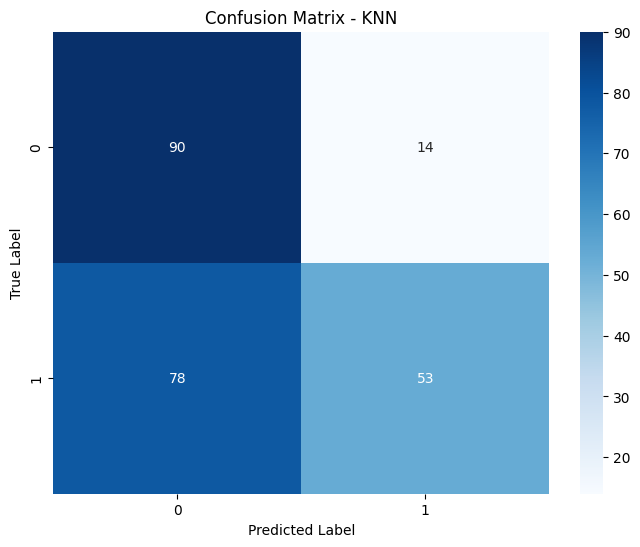


Training RF Model
Training on 939 samples...

Test Set Performance:
  Accuracy:  0.7277
  Precision: 0.7557
  Recall:    0.7557
  F1 Score:  0.7557

Classification Report:
              precision    recall  f1-score   support

         0.0       0.69      0.69      0.69       104
         1.0       0.76      0.76      0.76       131

    accuracy                           0.73       235
   macro avg       0.72      0.72      0.72       235
weighted avg       0.73      0.73      0.73       235



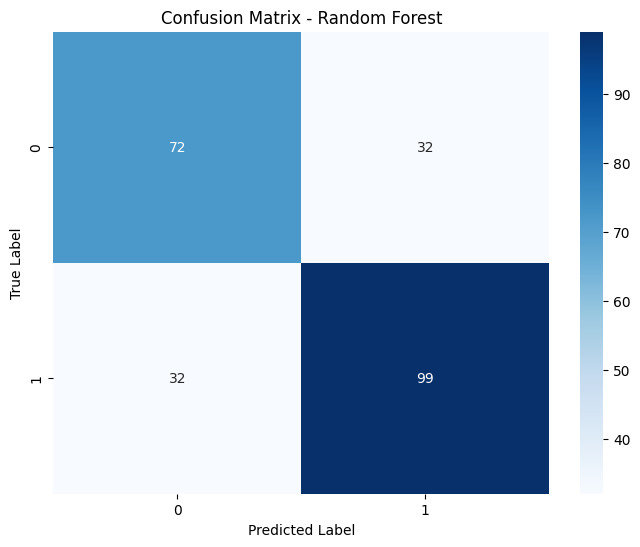


SHAP Feature Importance Analysis
Computing SHAP values...


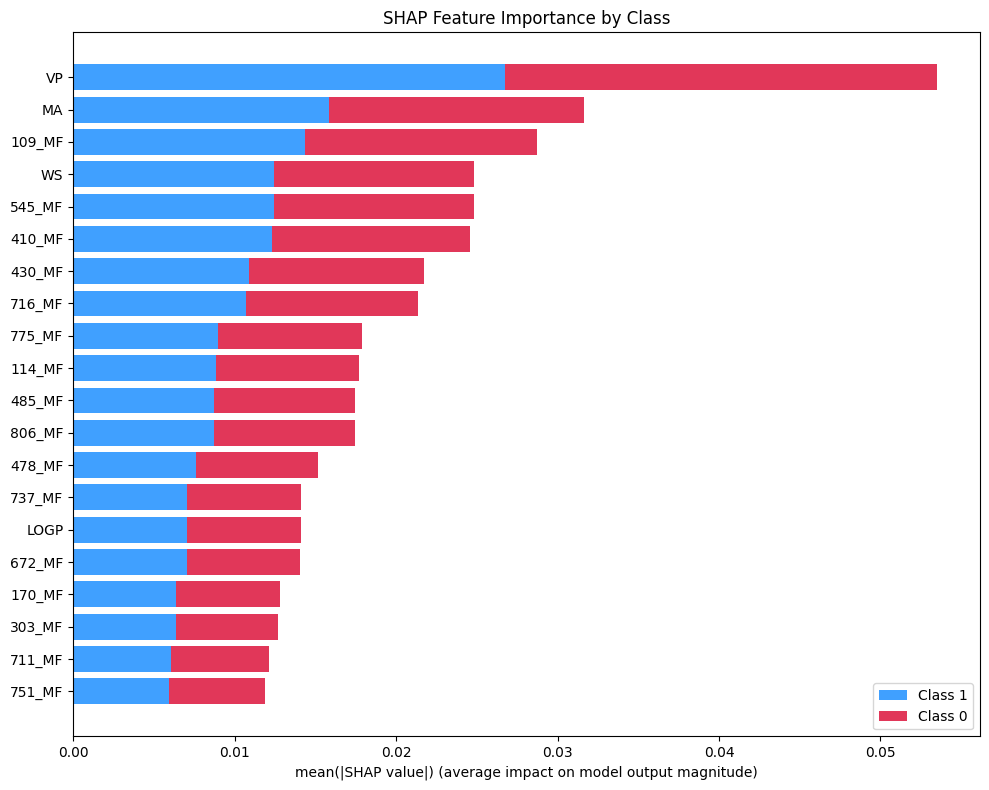

In [12]:
# ============================================================================
# SECTION 8: Train Models and Evaluate
# ============================================================================

models_trained = {}

if 'knn' in CONFIG['models_to_train']:
    model_knn, pred_knn = train_and_evaluate(
        X_train, y_train, X_test, y_test,
        model_type='knn',
        n_neighbors=4,
        weights='distance',
        algorithm='brute',
        metric='euclidean'
    )
    models_trained['knn'] = (model_knn, pred_knn)

    plot_confusion_matrix(y_test, pred_knn, "KNN")

if 'rf' in CONFIG['models_to_train']:
    model_rf, pred_rf = train_and_evaluate(
        X_train, y_train, X_test, y_test,
        model_type='rf',
        n_estimators=60, #55
        random_state=CONFIG['random_state']
    )
    models_trained['rf'] = (model_rf, pred_rf)

    plot_confusion_matrix(y_test, pred_rf, "Random Forest")

    # SHAP analysis
    perform_shap_analysis(model_rf, X_test)



In [14]:
# ============================================================================
# SECTION 9: Cross-Validation
# ============================================================================

print("\n" + "="*60)
print("CROSS-VALIDATION (ORIGINAL METHODOLOGY)")
print("="*60)

cv_results = {}

if 'knn' in CONFIG['models_to_train']:
    cv_scores_knn, cv_pred_knn = perform_cross_validation(
        train_fp,
        model_type='knn',
        n_splits=CONFIG['cv_folds'],
        fp_size=fp_size,
        label_col=CONFIG['label_column'],
        n_neighbors=4,
        weights='distance',
        algorithm='brute',
        metric='euclidean'
    )
    cv_results['knn'] = cv_scores_knn

if 'rf' in CONFIG['models_to_train']:
    cv_scores_rf, cv_pred_rf = perform_cross_validation(
        train_fp,
        model_type='rf',
        n_splits=CONFIG['cv_folds'],
        fp_size=fp_size,
        label_col=CONFIG['label_column'],
        n_estimators=55,
        random_state=CONFIG['random_state']
    )
    cv_results['rf'] = cv_scores_rf




CROSS-VALIDATION (ORIGINAL METHODOLOGY)

10-Fold Cross-Validation (KNN)
  Total samples: 939
  Features used: 881 (fingerprint only)
  Class distribution: {1: np.int64(525), 0: np.int64(414)}

Computing CV scores...

F1 Scores per fold:
  Fold 1: 0.5915
  Fold 2: 0.5570
  Fold 3: 0.5405
  Fold 4: 0.5238
  Fold 5: 0.5000
  Fold 6: 0.6667
  Fold 7: 0.4872
  Fold 8: 0.5934
  Fold 9: 0.5747
  Fold 10: 0.5227

CV F1 Mean: 0.5558, Std: 0.0505

Overall CV Performance:
  Accuracy:  0.6102
  Precision: 0.6509
  Recall:    0.6333
  F1 Score:  0.6045

10-Fold Cross-Validation (RF)
  Total samples: 939
  Features used: 881 (fingerprint only)
  Class distribution: {1: np.int64(525), 0: np.int64(414)}

Computing CV scores...

F1 Scores per fold:
  Fold 1: 0.6957
  Fold 2: 0.7059
  Fold 3: 0.6804
  Fold 4: 0.7500
  Fold 5: 0.7184
  Fold 6: 0.7407
  Fold 7: 0.7238
  Fold 8: 0.7455
  Fold 9: 0.7818
  Fold 10: 0.7586

CV F1 Mean: 0.7301, Std: 0.0294

Overall CV Performance:
  Accuracy:  0.7007
  Precis

In [ ]:
# ============================================================================
# SECTION 10: Summary and Results Download
# ============================================================================

print("\n" + "="*60)
print("ANALYSIS COMPLETE - SUMMARY")
print("="*60)

print("\nTest Set Results:")
for model_name, (model, pred) in models_trained.items():
    acc = accuracy_score(y_test, pred)
    f1 = f1_score(y_test, pred, zero_division=0)
    print(f"  {model_name.upper()}: Accuracy={acc:.4f}, F1={f1:.4f}")

print("\nCross-Validation Results:")
for model_name, scores in cv_results.items():
    print(f"  {model_name.upper()}: F1 Mean={scores.mean():.4f} ± {scores.std():.4f}")

# Save results for download
results_summary = {
    'model': [],
    'test_accuracy': [],
    'test_f1': [],
    'cv_f1_mean': [],
    'cv_f1_std': []
}

for model_name in CONFIG['models_to_train']:
    if model_name in models_trained:
        _, pred = models_trained[model_name]
        results_summary['model'].append(model_name)
        results_summary['test_accuracy'].append(accuracy_score(y_test, pred))
        results_summary['test_f1'].append(f1_score(y_test, pred, zero_division=0))
        results_summary['cv_f1_mean'].append(cv_results[model_name].mean())
        results_summary['cv_f1_std'].append(cv_results[model_name].std())

results_df = pd.DataFrame(results_summary)
results_df.to_csv('model_results_summary.csv', index=False)

print("\n✓ Results saved to 'model_results_summary.csv'")
print("  Download the file using: files.download('model_results_summary.csv')")

# Optionally download the results file
# files.download('model_results_summary.csv')

print("\n" + "="*60)
print("ALL DONE! 🎉")
print("="*60)